In [27]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.9.1


In [28]:
train_dir = Path('..content/train')
train_filepaths = list(train_dir.glob(r'**/*.*'))

In [29]:
test_dir = Path('..content/test')
test_filepaths = list(test_dir.glob(r'**/*.*'))

In [30]:
val_dir = Path('D:/fv/fvclass/validation')
val_filepaths = list(test_dir.glob(r'**/*.*'))

In [31]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [32]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [33]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 4223

Number of different labels: 46

Labels: ['turnip' 'pumpkin' 'sweetcorn' 'raddish' 'ginger' 'lemon' 'pineapple'
 'onion' 'potato' 'spinach' 'bean' 'jalepeno' 'orange' 'capsicum' 'banana'
 'peas' 'mutton' 'carrot' 'papaya' 'beetroot' 'tomato' 'mango'
 'sweetpotato' 'garlic' 'fish' 'eggplant' 'cucumber' 'chicken'
 'bitter gourd' 'kiwi' 'paprika' 'bottle gourd' 'corn' 'grapes'
 'watermelon' 'pomegranate' 'broccoli' 'pear' 'bellpepper' 'chilli pepper'
 'egg' 'cabbage' 'lettuce' 'cauliflower' 'soy beans' 'apple']


In [34]:
train_df.head(5)

,Filepath,Label
0,D:\fv\fvclass\train\turnip\Image_42.jpg,turnip
1,D:\fv\fvclass\train\pumpkin\0041.jpg,pumpkin
2,D:\fv\fvclass\train\sweetcorn\Image_8.jpg,sweetcorn
3,D:\fv\fvclass\train\raddish\Image_54.png,raddish
4,D:\fv\fvclass\train\ginger\Image_57.jpg,ginger


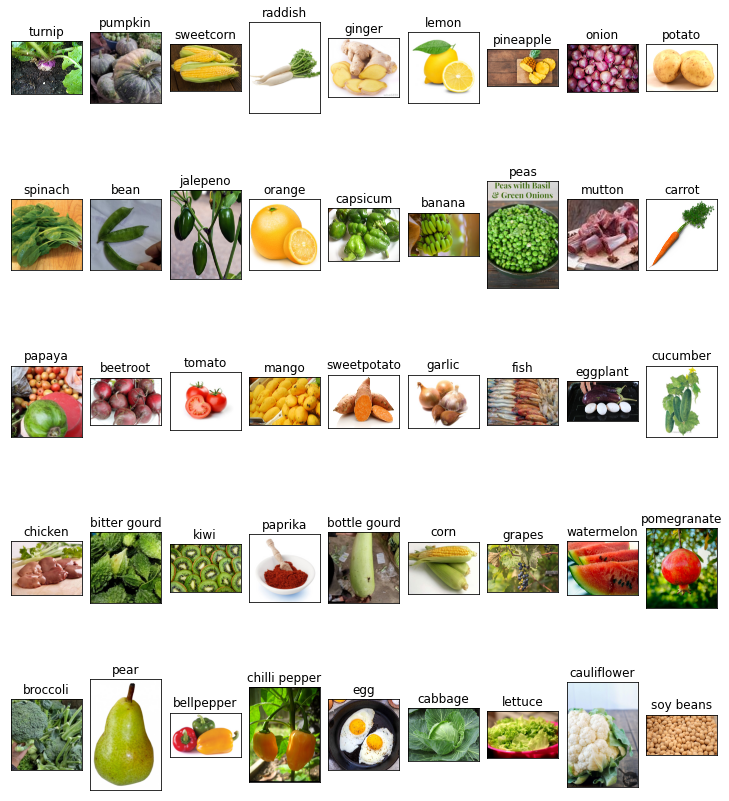

In [35]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=5, ncols=9, figsize=(10, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [36]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [37]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 4223 validated image filenames belonging to 46 classes.


In [38]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 477 validated image filenames belonging to 46 classes.


In [39]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 477 validated image filenames belonging to 46 classes.


In [40]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(46, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

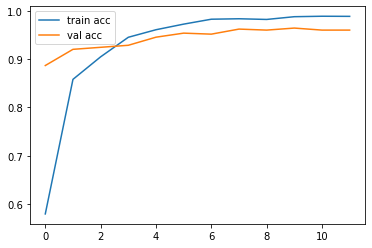

In [51]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [52]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

15/15 [==============================] - 16s 1s/step


['chicken',
 'bellpepper',
 'turnip',
 'beetroot',
 'turnip',
 'eggplant',
 'cabbage',
 'peas',
 'orange',
 'papaya',
 'chicken',
 'sweetcorn',
 'soy beans',
 'ginger',
 'carrot',
 'cauliflower',
 'lettuce',
 'papaya',
 'paprika',
 'cauliflower',
 'jalepeno',
 'fish',
 'fish',
 'mutton',
 'kiwi',
 'carrot',
 'soy beans',
 'egg',
 'watermelon',
 'bellpepper',
 'fish',
 'watermelon',
 'tomato',
 'turnip',
 'papaya',
 'kiwi',
 'papaya',
 'capsicum',
 'corn',
 'bottle gourd',
 'cabbage',
 'jalepeno',
 'chicken',
 'banana',
 'pumpkin',
 'tomato',
 'chilli pepper',
 'carrot',
 'onion',
 'kiwi',
 'watermelon',
 'mutton',
 'grapes',
 'jalepeno',
 'spinach',
 'apple',
 'papaya',
 'tomato',
 'onion',
 'onion',
 'watermelon',
 'bean',
 'onion',
 'potato',
 'bitter gourd',
 'potato',
 'pear',
 'bottle gourd',
 'lemon',
 'corn',
 'beetroot',
 'bean',
 'spinach',
 'lettuce',
 'mutton',
 'apple',
 'corn',
 'lemon',
 'bitter gourd',
 'corn',
 'papaya',
 'raddish',
 'cauliflower',
 'mutton',
 'soy bean

In [53]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [54]:
img = output('D:/fv/fvclass/test/cabbage/Image_1.jpg')
img

1/1 [==============================] - 1s 839ms/step


'cabbage'

In [55]:
model.save('FV.h5')

In [56]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score 
cm = confusion_matrix(test_images.classes, pred)  
cm

array([[ 8,  0,  0, ...,  0,  0,  0],
       [ 0,  7,  0, ...,  0,  0,  0],
       [ 0,  0, 10, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 10,  0,  0],
       [ 0,  0,  0, ...,  0, 10,  0],
       [ 0,  0,  0, ...,  0,  0, 10]], dtype=int64)

In [57]:
ps = precision_score(test_images.classes, pred, average='weighted')
print("PRECISION SCORE : ",ps)
rs = recall_score(test_images.classes, pred, average='weighted')
print("RECALL SCORE : ",rs) 
fs = f1_score(test_images.classes, pred, average='weighted')
print("F1 SCORE : ",fs) 

PRECISION SCORE :  0.9704819987838856
RECALL SCORE :  0.9643605870020965
F1 SCORE :  0.9648662669443673


<AxesSubplot:>

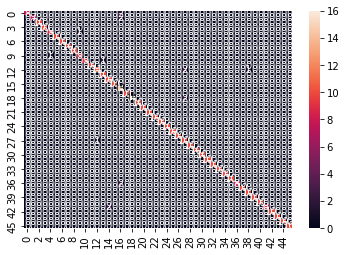

In [58]:
import seaborn as sns
sns.heatmap(cm,annot=True)